## Import Modules

In [1]:
# Data Processing
import numpy as np 
import pandas as pd
import scipy as sp
from functools import reduce

# Dim Reduction
from sklearn.decomposition import PCA

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#get inline plots
%matplotlib inline 


General Idea: Anomaly Detection using Statistical Methods
There's a distribution that belongs to inliers. Anomalies are not well modeled by the distribution.

Requirements:
- Data looks normal
    - If it's not, try transforming it.
- Little to no correlation.  Covariance matrix looks like:

In [15]:
print(np.array([[1,0],[0,1]]))

[[1 0]
 [0 1]]


In [3]:
def gen_outlier(n):
    whole = np.random.uniform(3,4, n)
    negative = np.random.uniform(0,1,n) < .5
    values = np.multiply(negative*(-2)+1,whole)
    return  values

def gen_outlier_frame(n,m):
    col_names = ['feature_' + str(i) for i in np.arange(1,m+1)]
    frame_out = pd.DataFrame(
        [list(gen_outlier(i)) for i in n*[m]], 
    columns = col_names)
    return frame_out

def gen_inlier_frame(n,m):
    col_names = ['feature_' + str(i) for i in np.arange(1,m+1)]
    frame_out = pd.DataFrame(np.random.normal(0,1, size = (n,m)), columns=col_names)
    return frame_out

def zscore(x):
    return (x - np.mean(x))/np.std(x)

## Generate Data

In [4]:
n_features = 5
outlier_n = 10
inlier_n = 1000

In [5]:
outlier = gen_outlier_frame(outlier_n,n_features)
inlier = gen_inlier_frame(inlier_n,n_features)

inlier['label'] = 'inlier'
outlier['label'] = 'outlier'
df = outlier.append(inlier)
df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,label
0,3.031398,3.755807,3.900333,-3.403586,-3.302614,outlier
1,-3.037511,3.358197,-3.087941,3.939158,3.277181,outlier
2,3.887008,3.072456,-3.148196,3.413749,3.017295,outlier
3,3.705119,-3.055653,-3.499318,3.263477,3.316467,outlier
4,3.228418,3.437232,3.424170,3.364838,-3.398070,outlier


## Plot Densities
- Plot Inlier Kernal Density Plot - Green
- Plot Inlier Kernal Density Plot - Red

C:\Users\Cglan\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


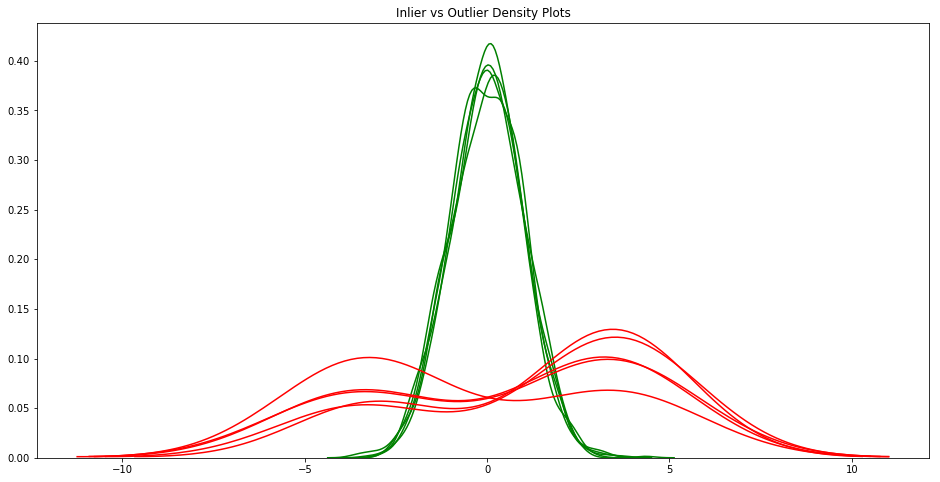

In [6]:
# you try, plot below all density curves

plt.figure(figsize=(16,8))
_ = inlier.drop('label',1).apply(lambda x: sns.kdeplot(x, color='green', legend = False), 0)
_ = outlier.drop('label',1).apply(lambda x: sns.kdeplot(x, color = 'red', legend = False), 0)
_ = plt.title('Inlier vs Outlier Density Plots')

## Get Probabilities
1. Create zscore for each column
2. Get Probabilities for each column
3. Get Joint Probabilities by multiplying P(Feature 1) * P(Feature 2) * P(Feature 3)
    - Note, this assumes independence assumption

In [7]:
# you try:

df_raw = df

# Step 1: normalize:
df_zscore = df.drop('label',1).apply(zscore,0)

# Step 2: Use sp.stats.norm.pdf on results above
df_p = df_zscore.apply(lambda x: np.round(sp.stats.norm.pdf(x),5),1)

# Step 3: get Probabilities of Feature_1 x Features_2 x .... Feature_n
df_raw['prob'] = round(df_p.apply(np.prod,1)*100,100)
df_raw.head(10)

,feature_1,feature_2,feature_3,feature_4,feature_5,label,prob
0,3.031398,3.755807,3.900333,-3.403586,-3.302614,outlier,6.370447e-13
1,-3.037511,3.358197,-3.087941,3.939158,3.277181,outlier,6.166763e-12
2,3.887008,3.072456,-3.148196,3.413749,3.017295,outlier,8.565735e-12
3,3.705119,-3.055653,-3.499318,3.263477,3.316467,outlier,4.064823e-12
4,3.228418,3.437232,3.424170,3.364838,-3.398070,outlier,5.684194e-12
5,3.402575,-3.448638,3.729452,3.567392,3.417359,outlier,5.985638e-13
6,-3.048384,3.392452,-3.651726,3.911629,3.271783,outlier,1.061570e-12
7,3.630015,3.401203,-3.261546,-3.636843,-3.693805,outlier,2.466948e-13
8,-3.260600,-3.809837,3.065954,3.361007,3.416382,outlier,4.732592e-12
9,3.423961,-3.993169,-3.286739,-3.428026,-3.820022,outlier,9.873939e-14


## Selecting an Epsilon
Because we have our data set labeled, we can identify an epsilon (threshold, aka "outlier fraction") using descriptive stats.


In [24]:
## Your Turn:
df = df_raw

# Create a a pivot table showing the min and max probabilities with index = label. Columns need to show "min" and "max"
# values should display min and max of "prob" column.


df.pivot_table(
    index = 'label',
    aggfunc=[np.min, np.max],
    values = 'prob').apply(
    lambda x: np.round(x, decimals = 8))

,amin,amax
label,,
inlier,0.000004,0.908516
outlier,0.000000,0.000000


In [25]:
epsilon = df[df.label == 'outlier'].prob.max()
mask =  [i<=epsilon for i in df_raw.prob]

df_raw['pred'] = ['outlier' if i <= epsilon else 'inlier' for i in df_raw.prob]

## Visualizing Outliers in 2D

Let's take a look at how our detection played out. First do a scatter plot of some features. Plot markers with outliers showing up as red and outliers showing up as green.

Set your features > 2 and use PCA with n_components = 2. Plot component 1 and 2 along X and Y axes. Color the markers the same way. 

**Hint**: You're doing two graphs.

**bonus**: make a kdeplotto show bivariate kernel density estimation

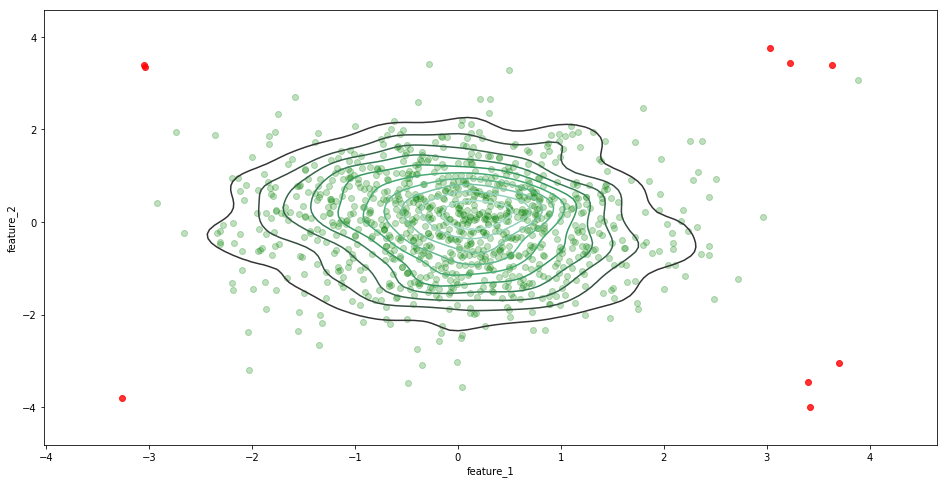

In [33]:
df_in = df_raw
mask = df_raw.prob < epsilon
plt.figure(figsize=(16,8))
# youre turn


sns.kdeplot(df_in.feature_1, df_in.feature_2)
sns.regplot(x="feature_1", y="feature_2", data=df_in[~mask],fit_reg=False,color='g',scatter_kws={'alpha':0.25})
sns.regplot(x="feature_1", y="feature_2", data=df_in[mask],fit_reg=False,color='red')

### Reduce dimensions to two using PCA

In [34]:
# your turn here:
two_dim = PCA(n_components= 2)
two_dim.fit(df_raw.drop(['prob','label','pred'],1).T)
two_dim_frame = pd.DataFrame(two_dim.components_.T, columns= ['PCA1','PCA2'])
two_dim_frame['pred'] = df_raw.pred.reset_index(drop = True)

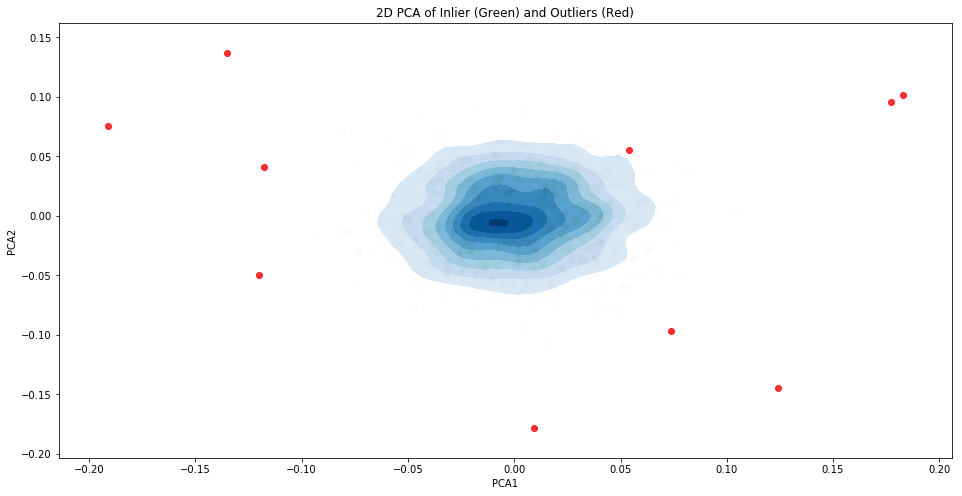

In [35]:
# set size
plt.figure(figsize=(16,8))

# Plot 1: Bi-Variate Density plot
sns.kdeplot(two_dim_frame['PCA1'], two_dim_frame['PCA2'], cmap="Blues", shade=True, shade_lowest=False, )

# Plot 2: Green Dots (inliers)
sns.regplot(x="PCA1", y="PCA2", data=two_dim_frame.iloc[0:10,],fit_reg=False,color='r')

# Plot 3: Red Dots (Outliers)
sns.regplot(x="PCA1", y="PCA2", data=two_dim_frame.iloc[11:,],fit_reg=False,color='g',scatter_kws={'alpha':0.01})

# Title
plt.title('2D PCA of Inlier (Green) and Outliers (Red)')

#### BONUS!!

Do a confusion matrix that shows true / false positives / negatives. 

In [14]:
confusion_matrix(y_true = df_raw.label, y_pred = df_raw.pred)

array([[1000,    0],
       [   0,   10]])